# Load data

In [2]:
import sys
import os
import numpy as np
import mne
import matplotlib.pyplot as plt

from mne.preprocessing import ICA
from pyprep.find_noisy_channels import NoisyChannels

from autoreject import AutoReject
from autoreject import get_rejection_threshold

from IPython import display

from scipy.io import savemat

# %matplotlib widget
%matplotlib inline

In [5]:
sub_num = 'C17'

In [6]:
data_dir = "../../../EEG DATA/"
save_dir = '../../../Matlab Code/Processed Data LOOP/'

sub_id=''; acq_id=''
for folder in os.listdir(data_dir):
    save_fname_fif = folder[:3] + '_preprocessed-raw.fif'
    # print(save_fname_fif)
    # print(save_fname_fif in os.listdir(save_dir))
    if (not folder.startswith('.') and folder.startswith(sub_num)):#and (folder[:3] in sub_fnames) and
    # (save_fname_fif not in os.listdir(save_dir))):
        sub_id = folder
    else:
        continue
for subfile in os.listdir(os.path.join(data_dir,sub_id)):
    if not subfile.endswith(".edf"):
        continue
    else:
        acq_id = subfile;
# sub_id = 'C5.EEGDATA'
# acq_id = 'C5 Part 2 experiment.edf'

# read data, set EOG channel, and drop unused channels
print(f"{sub_id}\nreading raw file...")
eeg_data_raw_file = os.path.join(data_dir,sub_id,acq_id)

raw = mne.io.read_raw_edf(eeg_data_raw_file)
# except:
#     print('Raw file corrupted.');
#     with open(f'{folder[:3]}_corrupted.txt', 'w') as f:
#         f.write('raw file corrupted.'); continue
#     continue
eog_idx = len(raw.ch_names)-4; del raw
raw = mne.io.read_raw_edf(eeg_data_raw_file, eog=[eog_idx], preload=True)
display.clear_output(wait=True)

# high level inspection
print(raw.ch_names)
print(len(raw.ch_names))

# # # drop non EEG channels
non_eeg_chs = raw.ch_names[len(raw.ch_names)-3:len(raw.ch_names)]
raw.drop_channels(non_eeg_chs); raw.drop_channels(raw.ch_names[-2]);
# raw.drop_channels(['FT7','FT8','PO5','PO6']) # for C24,055,056, 047

raw

['Fp1', 'Fpz', 'Fp2', 'AF3', 'AF4', 'F11', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'F12', 'FT11', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT12', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'M1', 'M2', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Cb1', 'Cb2', 'VEOG', 'HEOG', 'EKG', 'EMG', 'Trigger']
69


<RawEDF | Acquisition 20 Data.edf, 65 x 1438400 (1438.4 s), ~713.4 MB, data loaded>

In [11]:
# raw.load_data().apply_function(lambda x: x, dtype='float64') # hilbert makes dtype complex128

In [12]:
# elaborated raw.info 
n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names)  # note: there is no raw.n_channels attribute
print('The raw data object has {} time samples and {} channels.'
      ''.format(n_time_samps, n_chan))
print('The last time sample is at {} seconds.'.format(time_secs[-1]))
print('The first few channel names are {}.'.format(', '.join(ch_names[:3])))
print()  # insert a blank line in the output

print(raw.info)
# raw.load_data()
raw.info

The raw data object has 1339600 time samples and 69 channels.
The last time sample is at 1339.599 seconds.
The first few channel names are Fp1, Fpz, Fp2.

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, AF3, AF4, F11, F7, F5, F3, F1, Fz, F2, F4, F6, ...
 chs: 67 EEG, 1 EOG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2022-01-19 09:58:56 UTC
 nchan: 69
 projs: []
 sfreq: 1000.0 Hz
>


<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, AF3, AF4, F11, F7, F5, F3, F1, Fz, F2, F4, F6, ...
 chs: 67 EEG, 1 EOG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2022-01-19 09:58:56 UTC
 nchan: 69
 projs: []
 sfreq: 1000.0 Hz
>

In [13]:
ch_names = raw.ch_names
print(ch_names)

['Fp1', 'Fpz', 'Fp2', 'AF3', 'AF4', 'F11', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'F12', 'FT11', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT12', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'M1', 'M2', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Cb1', 'Cb2', 'VEOG', 'HEOG', 'EKG', 'EMG', 'Trigger']


In [14]:
raw.drop_channels(['HEOG','EKG','EMG']) # drop unused
print(raw.info) # recheck raw info
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, AF3, AF4, F11, F7, F5, F3, F1, Fz, F2, F4, F6, ...
 chs: 64 EEG, 1 EOG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2022-01-19 09:58:56 UTC
 nchan: 66
 projs: []
 sfreq: 1000.0 Hz
>


<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, AF3, AF4, F11, F7, F5, F3, F1, Fz, F2, F4, F6, ...
 chs: 64 EEG, 1 EOG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2022-01-19 09:58:56 UTC
 nchan: 66
 projs: []
 sfreq: 1000.0 Hz
>

In [15]:
ch_names = raw.ch_names
print(len(ch_names))
print(ch_names)

66
['Fp1', 'Fpz', 'Fp2', 'AF3', 'AF4', 'F11', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'F12', 'FT11', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT12', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'M1', 'M2', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Cb1', 'Cb2', 'VEOG', 'Trigger']


# Modifying Data In-Place

In [7]:
# original_raw = raw.copy()
# raw.apply_hilbert()
# print(f'original data type was {original_raw.get_data().dtype}, after '
#       f'apply_hilbert the data type changed to {raw.get_data().dtype}.')

Using matplotlib as 2D backend.
Opening raw-browser...


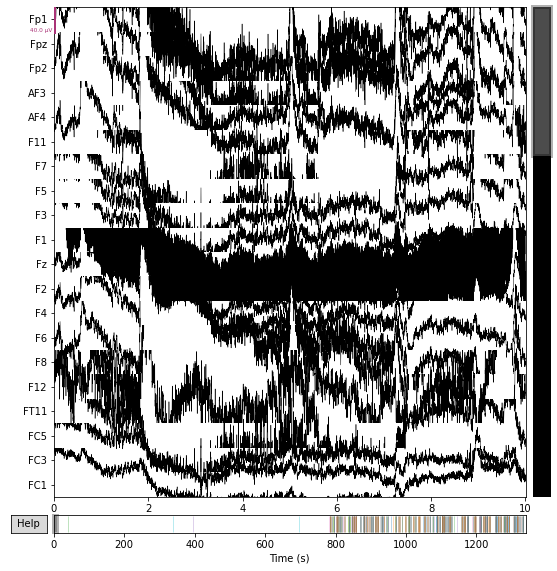

In [9]:
# rereferenced_raw, ref_data = mne.set_eeg_reference(original_raw, ['Cz'],
#                                                    copy=True)
fig_orig = raw.plot()
# fig_reref = rereferenced_raw.plot()

# Parsing events from raw data

In [10]:
print(type(label))
print(label)

<class 'mne.annotations.Annotations'>
<Annotations | 540 segments: 1000001 (132), 1000010 (132), 1100001 (106), ...>


In [11]:
# annot contents
print(len(raw.annotations))
print(set(raw.annotations.duration))
print(set(raw.annotations.description))
print(raw.annotations.onset[0])

540
{0.0}
{'Med Pain Hand', 'eyes opened', 'No Pain Hand', '1000010', '1000001', '1100001', 'Stop', 'Yes Pain Hand', 'Yes Pain Back', 'No Pain Back', '1100010', 'Med Pain Back', 'eyes closed'}
40.563


In [12]:
# # from raw.annotations docstring:
# # remove epochs with blinks

# eog_events = mne.preprocessing.find_eog_events(raw)  # doctest: +SKIP
# n_blinks = len(eog_events)  # doctest: +SKIP
# onset = eog_events[:, 0] / raw.info['sfreq'] - 0.25  # doctest: +SKIP
# duration = np.repeat(0.5, n_blinks)  # doctest: +SKIP
# description = ['bad blink'] * n_blinks  # doctest: +SKIP
# annotations = mne.Annotations(onset, duration, description)  # doctest: +SKIP
# blink_raw = raw.copy()
# blink_raw.set_annotations(annotations)  # doctest: +SKIP
# epochs = mne.Epochs(blink_raw, events, event_id, tmin, tmax)  # doctest: +SKIP

In [13]:
custom_mapping = {'eyes closed': 1, 'eyes opened': 2, 'Yes Pain Hand': 3, 
                  'Med Pain Hand': 4,  'No Pain Hand': 5, 'Yes Pain Back': 6, 
                  'Med Pain Back': 7, 'No Pain Back': 8, 'Stop': 9, 
                  '1000001': 10, '1000010': 11, '1100001': 12, '1100010': 13, # 65, 66, 97, 98
                  }
(events_from_annot, event_dict) = mne.events_from_annotations(raw, event_id=custom_mapping)
print(event_dict)
print(events_from_annot[:5])

Used Annotations descriptions: ['1000001', '1000010', '1100001', '1100010', 'Med Pain Back', 'Med Pain Hand', 'No Pain Back', 'No Pain Hand', 'Stop', 'Yes Pain Back', 'Yes Pain Hand', 'eyes closed', 'eyes opened']
{'1000001': 10, '1000010': 11, '1100001': 12, '1100010': 13, 'Med Pain Back': 7, 'Med Pain Hand': 4, 'No Pain Back': 8, 'No Pain Hand': 5, 'Stop': 9, 'Yes Pain Back': 6, 'Yes Pain Hand': 3, 'eyes closed': 1, 'eyes opened': 2}
[[ 40563      0      1]
 [338400      0      9]
 [396094      0      2]
 [696594      0      9]
 [782044      0      4]]


In [14]:
raw.annotations

<Annotations | 540 segments: 1000001 (132), 1000010 (132), 1100001 (106), ...>

Opening raw-browser...


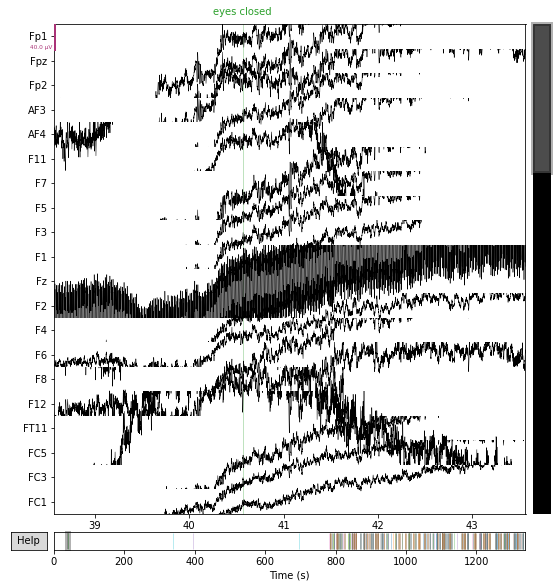

Opening raw-browser...


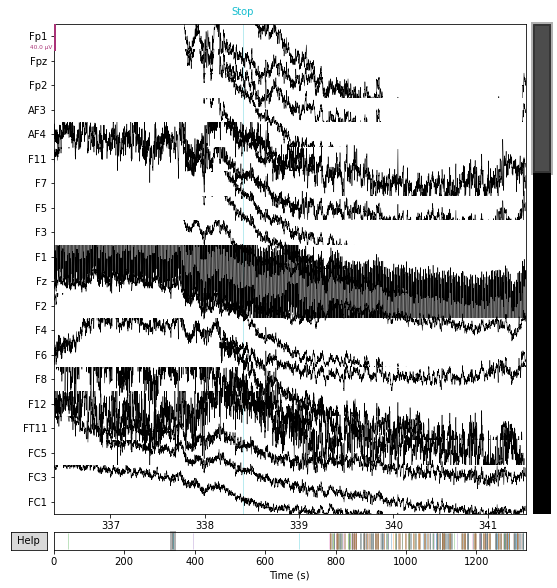

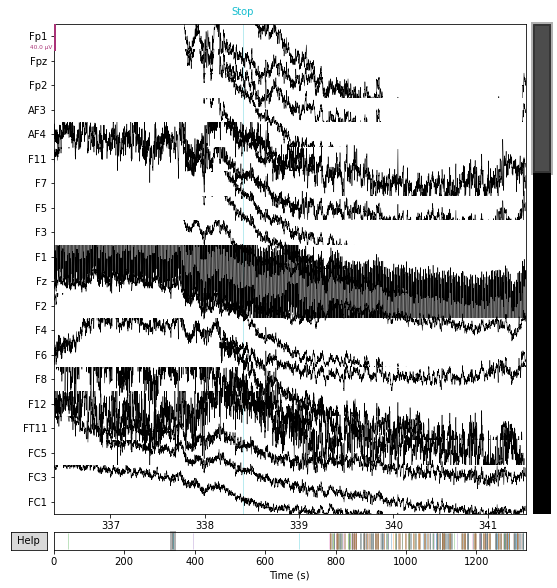

In [15]:
raw.plot(start=raw.annotations.onset[0]-2, duration=5)
raw.plot(start=raw.annotations.onset[1]-2, duration=5)

# Info object

In [16]:
info = raw.info
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, AF3, AF4, F11, F7, F5, F3, F1, Fz, F2, F4, F6, ...
 chs: 64 EEG, 1 EOG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2022-01-19 09:58:56 UTC
 nchan: 66
 projs: []
 sfreq: 1000.0 Hz
>


In [17]:
# extract channels of a certain type, e.g., along 'z' midline
z_chs = mne.pick_channels_regexp(info['ch_names'], '.z')
print(z_chs) # indices
print([ch_names[z] for z in z_chs]) # names
print(ch_names[z] for z in z_chs) # pointer?

[10, 29, 49, 60]
['Fz', 'Cz', 'Pz', 'Oz']
<generator object <genexpr> at 0x7fac03ed4dd0>


In [18]:
# channel type from index
picks = (0, 16, 64, 65)
print([mne.channel_type(info, x) for x in picks])
print(raw.get_channel_types(picks=picks))

['eeg', 'eeg', 'eog', 'stim']
['eeg', 'eeg', 'eog', 'stim']


# Working with sensor locations

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt

# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')
sample_raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True, verbose=False)

In [20]:
montage_dir = os.path.join(os.path.dirname(mne.__file__),
                           'channels', 'data', 'montages')
print('\nBUILT-IN MONTAGE FILES')
print('======================')
print(sorted(os.listdir(montage_dir)))


BUILT-IN MONTAGE FILES
['EGI_256.csd', 'GSN-HydroCel-128.sfp', 'GSN-HydroCel-129.sfp', 'GSN-HydroCel-256.sfp', 'GSN-HydroCel-257.sfp', 'GSN-HydroCel-32.sfp', 'GSN-HydroCel-64_1.0.sfp', 'GSN-HydroCel-65_1.0.sfp', 'artinis-brite23.elc', 'artinis-octamon.elc', 'biosemi128.txt', 'biosemi16.txt', 'biosemi160.txt', 'biosemi256.txt', 'biosemi32.txt', 'biosemi64.txt', 'easycap-M1.txt', 'easycap-M10.txt', 'mgh60.elc', 'mgh70.elc', 'standard_1005.elc', 'standard_1020.elc', 'standard_alphabetic.elc', 'standard_postfixed.elc', 'standard_prefixed.elc', 'standard_primed.elc']


In [21]:
ten_twenty_montage = mne.channels.make_standard_montage('biosemi64')
print(ten_twenty_montage)
print(ten_twenty_montage.ch_names)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 64 channels>
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']


In [22]:
# cannot run this because channel names do not match
# raw_1020 = raw.copy().set_montage(ten_twenty_montage)

In [23]:
mon = sample_raw.get_montage()

Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


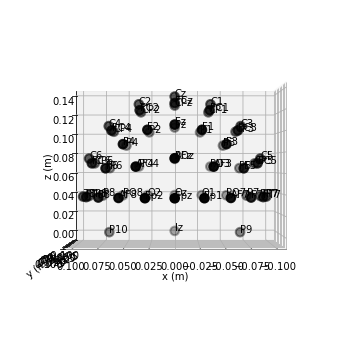

Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


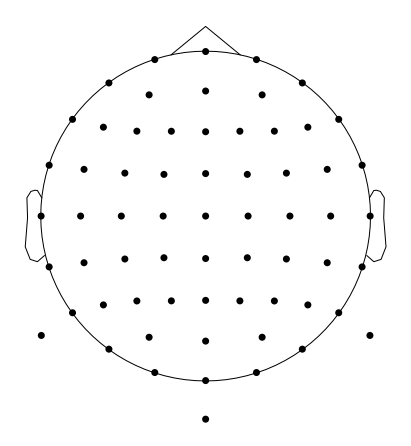

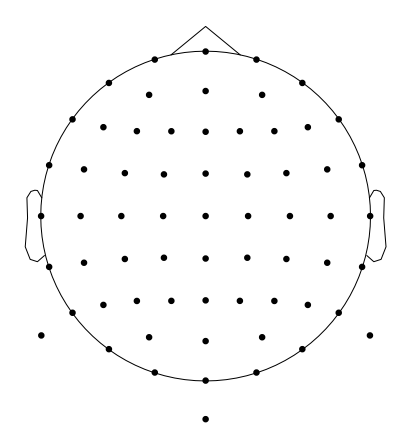

In [24]:
fig = ten_twenty_montage.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)  # set view angle
ten_twenty_montage.plot(sphere=(0, 0, 0.035, 0.094),kind='topomap', show_names=False)

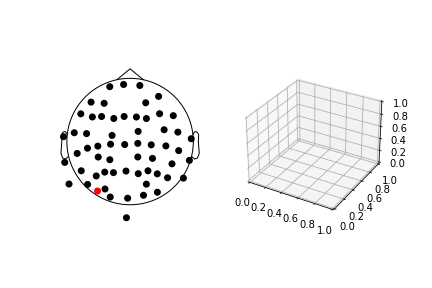

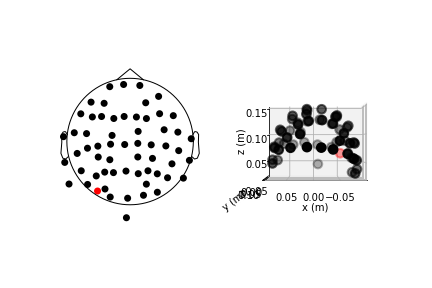

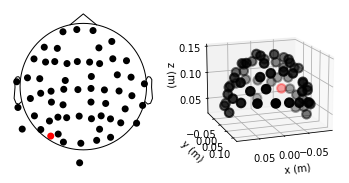

In [25]:
%matplotlib widget
fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
sample_raw.plot_sensors(ch_type='eeg', axes=ax2d)
sample_raw.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d')
ax3d.view_init(azim=70, elev=15)

In [26]:
%matplotlib inline

# Working with Layouts

In [27]:
layout_dir = os.path.join(os.path.dirname(mne.__file__),
                          'channels', 'data', 'layouts')
print('\nBUILT-IN LAYOUT FILES')
print('=====================')
print(sorted(os.listdir(layout_dir)))


BUILT-IN LAYOUT FILES
['CTF-275.lout', 'CTF151.lay', 'CTF275.lay', 'EEG1005.lay', 'EGI256.lout', 'KIT-125.lout', 'KIT-157.lout', 'KIT-160.lay', 'KIT-AD.lout', 'KIT-AS-2008.lout', 'KIT-UMD-3.lout', 'Neuromag_122.lout', 'Vectorview-all.lout', 'Vectorview-grad.lout', 'Vectorview-grad_norm.lout', 'Vectorview-mag.lout', 'biosemi.lay', 'magnesWH3600.lout']


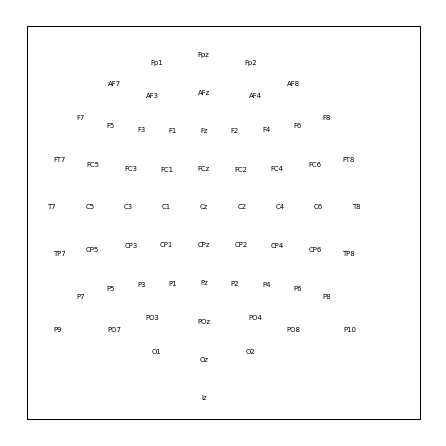

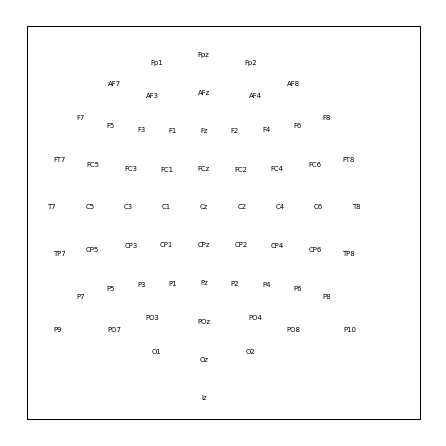

In [28]:
biosemi_layout = mne.channels.read_layout('biosemi')
biosemi_layout.plot()  # same result as mne.viz.plot_layout(biosemi_layout)

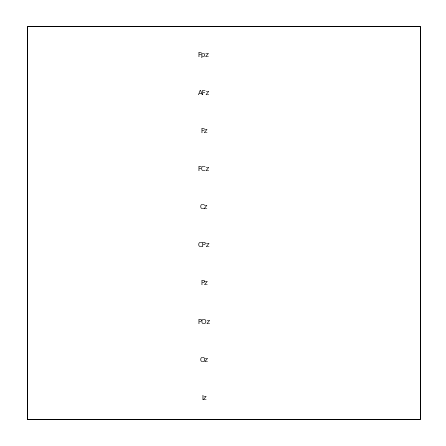

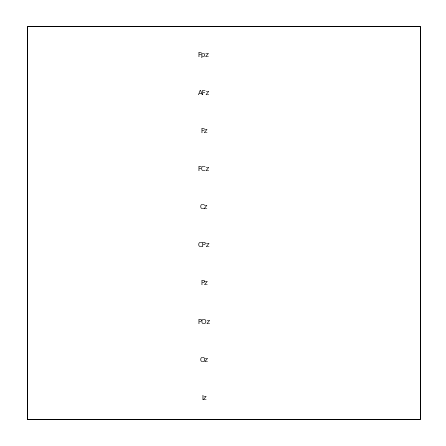

In [29]:
midline = np.where([name.endswith('z') for name in biosemi_layout.names])[0]
biosemi_layout.plot(picks=midline)

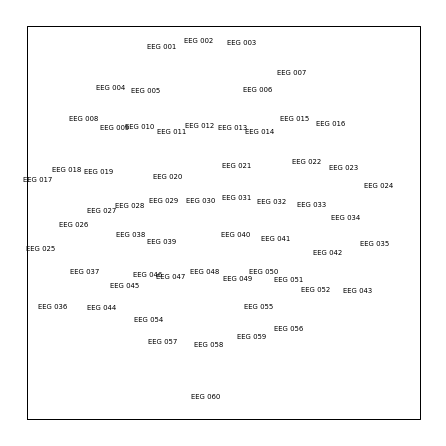

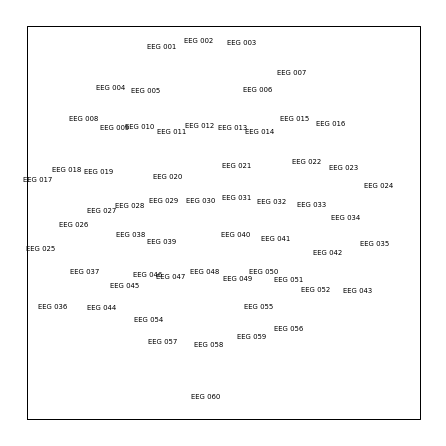

In [30]:
layout_from_raw = mne.channels.make_eeg_layout(sample_raw.info)
# same result as mne.channels.find_layout(raw.info, ch_type='eeg')
layout_from_raw.plot()

# Overview of artifact detection

Opening raw-browser...


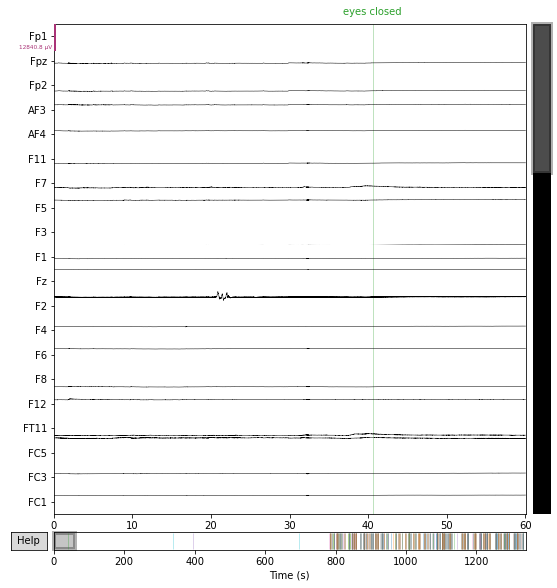

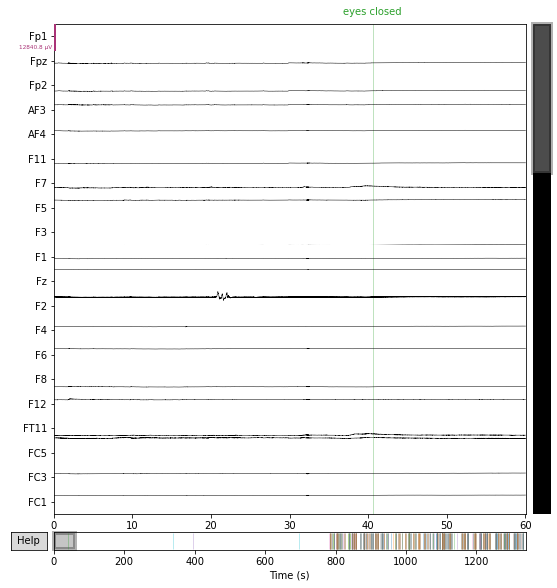

In [36]:
# plot first 60 seconds of raw EEG
eeg_channels = mne.pick_types(info, eeg=True, eog=False, stim=False)
raw.plot(duration=60, start=0, use_opengl=True, n_channels=20, # order=eeg_channels, n_channels=len(eeg_channels), 
         scalings='auto', remove_dc=False) 

In [32]:
# highpass at 0.1?

Effective window size : 2.048 (s)


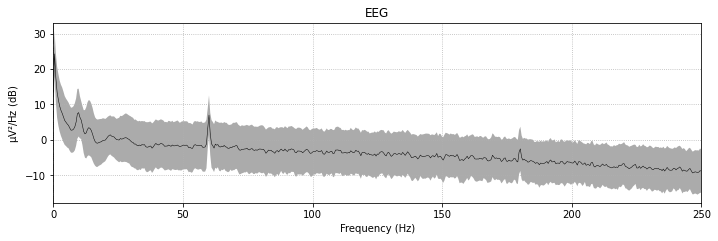

In [33]:
fig = raw.plot_psd(tmax=np.inf, fmax=250, average=True)
# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)

In [37]:
# need 60 Hz and harmonics filters

Using EOG channel: VEOG
EOG channel index for this subject is: [64]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 422 significant peaks
Number of EOG events detected: 422
Not setting metadata
422 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 422 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
422 matching events found
No basel

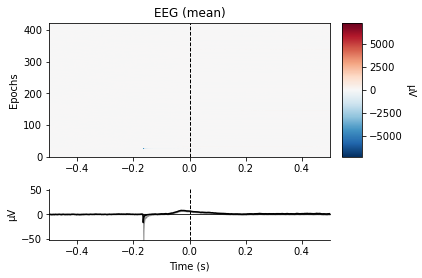

[<Figure size 432x288 with 3 Axes>]

In [38]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2))
eog_epochs.plot_image(combine='mean')
# eog_epochs.average().plot_joint()

# Save preprocessed data as FIF

In [ ]:
# raw.save('../Matlab Code/preprocessed_eeg.fif', verbose=True, overwrite=True)
# label.save('../Matlab Code/dropped_annot.txt',verbose=True)